### Co-visibilidad Evaluation

This code implements the evaluation of the proposed co-visibility detection system.
The co-visibility estimate is compared with the ground-truth value.

### Libreries

In [30]:
import json
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

### Estimated co-visibility matrix
These functions calculate the co-visibility matrix with the proposed method.

In [17]:
def occupancy(pts1,pts2,cell_x,cell_y,size):
# This function calculates the percentage of co-visibility between two images based on the position of the inliers.
# An occupancy grid is defined for each image, where cells containing one or more inliers are marked as occupied.
# The occupancy percentage is calculated as the number of occupied cells divided by the total number of cells.
# The highest occupancy value among the images is chosen to establish the co-visibility percentage in order to obtain a symmetric adjacency matrix.
#   -Input:
#       pts1, pts2      ---> Lists of inliers, positions of features on the image plane.
#       cell_x, cell_y  ---> Occupancy cell size.
#       size            ---> Size of the original images (x,y).
#   -Return: 
#       w               ---> Occupancy percentage, co-visibility value of the edge connecting the nodes.

    # Defining occupancy cells for each image:
    occupancy1=np.array([[0 for i in range(cell_y)] for j in range(cell_x)])
    occupancy2=np.array([[0 for i in range(cell_y)] for j in range(cell_x)])
  
    # We iterate through the lists of inliers and mark the occupied cells.
    iter=len(pts1)
    for i in range(iter):
        #Occupancy 1:
        x1=pts1[i][0]   # X position on the image plane.
        y1=pts1[i][1]   # Y position on the image plane.
        # Adjusting to the size of the occupancy cell:
        x1_idx=np.int32((x1*cell_x)/size[1])    
        y1_idx=np.int32((y1*cell_y)/size[0])
        # Marking the cell as occupied:
        occupancy1[x1_idx][y1_idx]=1
       
        #Occupancy 2:
        x2=pts2[i][0]   # X position on the image plane.
        y2=pts2[i][1]   # Y position on the image plane.
        # Adjusting to the size of the occupancy cel
        x2_idx=np.int32((x2*cell_x)/size[1])
        y2_idx=np.int32((y2*cell_y)/size[0])
        # Marking the cell as occupied:
        occupancy2[x2_idx][y2_idx]=1
    
    # Summing the occupied cells:
    sum1=0
    sum2=0
    for i in range(cell_y):
        for j in range(cell_x):
            if(occupancy1[j][i]==1):
                sum1+=1
            if(occupancy2[j][i]==1):
                sum2+=1
    
    # Calculating the occupancy percentage as the number of occupied cells divided by the total number of cells:
    occupancy_size=cell_x*cell_y
    w1=np.float64(sum1/occupancy_size)
    w2=np.float64(sum2/occupancy_size)

    # Selecting the maximum occupancy value as the co-visibility percentage between the images.
    w=np.max([w1,w2])   # This is done to achieve a symmetric adjacency matrix for the Appearance Graph.

    return w

In [18]:
def overlap_matrix(im_dir,im_path,umb_F):
    # This function calculates the co-visibility matrix for a threshold value 'umb_F' from a list of image names.
    # The co-visibility detection process is carried out with all the image pairs in the list
    #   -Input:
    #       im_dir          ---> List with image names
    #       im_path         ---> Image directory
    #       umb_F           ---> Threshold number of inliers to determine the existence of co-visibility
    #   -Return: 
    #       overlap         ---> Binary co-visibility matrix, save True or False depending on whether co-visibility is detected
    #       covisibilidad   ---> Real co-visibility matrix with the percentage of overlap between images

    # Calculation of the number of iterations to show the evolution of the process
    im_size=len(im_dir)
    total_iter=(im_size**2 + im_size)/2 
    cont_iter=0


    # Return matrix:
    overlap=np.array([[0 for i in range(im_size)] for j in range(im_size)]) # Matrix of binary co-visibility matrix, the result of the co-visibility detection is saved
    covisibilidad=np.array([[0 for i in range(im_size)] for j in range(im_size)])       # Real co-visibility matrix, the percentage of co-visibility is saved

    # SIFT descriptor class:
    sift=cv.xfeatures2d.SIFT_create()

    # Loop comparing pairs of images:
    for i in range(im_size):
        # Load image 1
        suffix1=im_dir[i]
        im1=cv.imread(im_path+'/'+suffix1)

        # Calculate SIFT descriptor for image 1, return feature descriptors (d) and keypoints (kp)
        kp1, des1 = sift.detectAndCompute(im1,None)
        
        for j in range(i,im_size):
                # Load image 2
                suffix2=im_dir[j]
                im2=cv.imread(im_path+'/'+suffix2)
                
                # If they are the same image (i==j) assign co-visibility equal to 1
                if i==j:
                    overlap[i][j]=True
                    covisibilidad[i][j]=1
                    
                else:
                    # Calculate SIFT descriptor for image 2, return feature descriptors (d) and keypoints (kp)
                    kp2, des2 = sift.detectAndCompute(im2,None)

                    # Descriptor matching by the Brute-Force-Matcher (BFM) method
                    if len(kp1) > 0 and len(kp2) > 0:
                        # BFMatcher
                        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)      # BFM class with positive cross-correlation (crossCheck=True).
                        matches = bf.match(des1,des2)                       # Matching of feature descriptors (d).
                        matches=sorted(matches, key= lambda x:x.distance)   # The matches are ordered from least to greatest distance between pairs of descriptors.
                        if len(matches)>100: matches=matches[:100]          # It operates with the 100 matches with the shortest distance, the best correspondences.
                        
                        # We obtain keypoints with correspondence:
                        pts1=[]
                        pts2=[]

                        for mat in matches:
                            pts1.append(kp1[mat.queryIdx].pt)
                            pts2.append(kp2[mat.trainIdx].pt)
                        
                        pts1=np.int32(np.array(pts1))
                        pts2=np.int32(np.array(pts2))
                        

                         # Calculation of the Fundamental Matrix (F) with RANSAC algorithm
                        if len(pts1)>=50: 
                            F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC,3,0.99,10) # Fundamental Matrix calculation, nº iterations in RANSAC algorithm = 10

                            # We select inliers, pairs of keypoints represented by the Fundamental Matrix obtained
                            pts1 = pts1[mask.ravel()==1]
                            pts2 = pts2[mask.ravel()==1]
            
                            # Co-visibility detection based on the number of inliers threshold
                            if len(pts1)>umb_F:
                                OVERLAP_ENABLE=True

                                # We store positive co-visibility
                                overlap[i, j]=True
                                overlap[j, i]=True

                                # We calculate the percentage of co-visibility
                                tam=im1.shape
                                # Occupancy cell size
                                cell_x=4
                                cell_y=np.int32((tam[0]/tam[1])*cell_x)

                                # Occupancy percentage calculation
                                cov_ratio=occupancy(pts1,pts2,cell_x,cell_y,tam)
                                # Save occupancy percentage in symmetric co-visibility matrix
                                covisibilidad[i, j]=cov_ratio
                                covisibilidad[j, i]=cov_ratio

                                del cov_ratio

                                del pts1,pts2

                # Print percentage of execution:
                cont_iter+=1
                if j%10==0: print('Proceso: ',np.round((cont_iter/total_iter)*100,decimals=6),'%',end='\r')
    
    return overlap, covisibilidad

### Ground-truth Co-visibility Matrix
This matrix stores the actual co-visibility values between pairs of images in the dataset.

In [20]:
def gt_matrix(im_path):
    # This function calculates the co-visibility matrix of true values from the name of the elements of the ordered dataset.
    # In this dataset, co-visible images are saved with a characteristic name of the place they represent.

    im_dir=sorted(os.listdir(im_path))  # Images names list
    mat_size=len(im_dir)

    # Initialization of the ground-truth array with the size of the list of images
    ground_truth=[[0 for i in range(mat_size)] for j in range(mat_size)]

    # The list of images is traversed in a nested loop to compare their names:
    for i, suffix1 in enumerate(im_dir):    
        for j, suffix2 in enumerate(im_dir):
            # If the name of the images are the same, determine co-visibility 1
            if suffix1 == suffix2: ground_truth[i][j]=1

            else:
                # Gets the place tag of the image names
                label1=suffix1.partition("_")[0]
                label2=suffix2.partition("_")[0]
                # If the tags match they are marked as co-visible:
                if label1 == label2: ground_truth[i][j]=1
                
    return ground_truth

### Evaluation - Precision and Recall
In this part, the function that calculates the precision and sensitivity of an estimated co-visibility matrix is implemented by comparing it with the ground-truth matrix.

In [21]:
def eval_PR(covisibilidad, ground_truth):
# This function compares element by element the values of the estimated co-visibility matrix and the ground-truth matrix.
# Depending on whether the prediction is correct or not, 4 situations are determined: True Positive, False Positive and False Negative.
# Based on these values, the precision and sensitivity are calculated
#   -Input:
#       covisibilidad  ---> Estimated co-visibility matrix
#       ground_truth   ---> Ground-truth co-visibility matrix
#   -Return: 
#       Precision      ---> Precision obtained by the estimated co-visibility matrix
#       Recall         ---> Sensitivity obtained by the estimated co-visibility matrix

    # Initialization of variables
    TP=0    # True Positive: The positive co-visibility estimate is correct
    FP=0    # False Positive: The positive co-visibility estimate is incorrect
    FN=0    # False Negative: The negative co-visibility estimate is incorrect

    # The rows and columns of the co-visibility and ground truth matrices are traversed
    for i in range(covisibilidad.shape[0]):
        for j in range(covisibilidad.shape[1]):
            # The cases of TP, FP and FN are determined:
            if covisibilidad[i][j] == True and ground_truth[i][j]==True: TP+=1
            if covisibilidad[i][j] == False and ground_truth[i][j]==True: FN+=1
            if covisibilidad[i][j] == True and ground_truth[i][j]==False: FP+=1

    # Precision and recall values are calculated
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    return Precision, Recall

## Co-visibility evaluation
In this part, a sweep of the threshold is performed, which determines the number of inliers of the co-visibility detection process.

The Precision and Recall values for each matrix obtained are compared.

In [ ]:
# Define range of values
trh_F=np.arange(2,40,2) 
trh_F=[int(i) for i in trh_F]

# Directory:
im_path=".../Test/Images"             # Directory of images of the controlled dataset
save_im_path=".../Covisibilidad_trhVariable/"  # Directory to save the co-visibility matrices obtained
seq_arr=["cloudy","night","sunny"]      # Different sequences of the controlled dataset for the evaluation

# Iterates over the different datasets
for seq in seq_arr:
    # Initialize precision and sensitivity lists for different threshold values
    P_hist=[]
    R_hist=[]

    # A co-visibility matrix is calculated for each value in the range of values of the parameter
    for i in range(len(trh_F)):
        # Images name list
        im_dir=sorted(os.listdir(im_path+seq))

        # Indicates execution process:
        print('Epoch: ',i,' / ',len(trh_F))

        # Calculation of estimated co-visibility matrices and ground-truth
        overlap,w, match_arr=overlap_matrix(im_dir,im_path+seq,trh_F[i])    # The co-visibility matrix is calculated for each threshold
        ground_truth=gt_matrix(im_path+seq)

        # Saves the co-visibility matrix obtained
        fig_path=save_im_path+"Fig_COLD_"+seq+"_ovl_Thr"+str(trh_F[i])+".npy"
        np.save(fig_path,w)

        # Calculation of precision and sensitivity for the co-visibility matrix obtained
        P, R = eval_PR(overlap,ground_truth)

        # Saves the evaluation result for each threshold
        P_hist.append(P)
        R_hist.append(R)

    # Saves precision and sensitivity lists for each dataset used
    save_dict={}
    save_dict.update({"Precision":P_hist})
    save_dict.update({"Recall":R_hist})
    save_dict.update({"Trheshold_cov":trh_F})

    save_json=".../Utils/Cov_PR_COLD_"+seq+".json"
    with open(save_json, "w") as outfile:
        json.dump(save_dict, outfile)
    

## Plot results - PR curve
The precision and recall curves are plotted for the different threshold values on the three datasets used.

In [22]:
cloudy_eval=json.load(open(".../Utils/Cov_PR_COLD_cloudy.json"))
night_eval=json.load(open(".../Utils/Cov_PR_COLD_night.json"))
sunny_eval=json.load(open(".../Utils/Cov_PR_COLD_sunny.json"))

Trh=cloudy_eval["Trheshold_cov"]
n=len(Trh)
cloudy_P=cloudy_eval["Precision"]
cloudy_R=cloudy_eval["Recall"]
night_P=night_eval["Precision"]
night_R=night_eval["Recall"]
sunny_P=sunny_eval["Precision"]
sunny_R=sunny_eval["Recall"]


Precision curve

Text(0.5, 1.0, 'Curva de Precisión para la detección de Co-visibilidad')

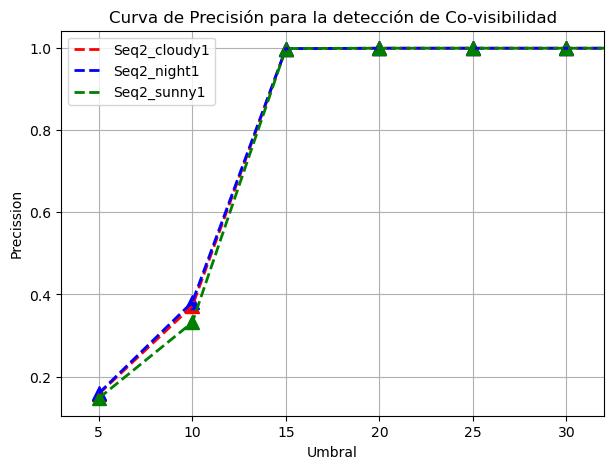

In [25]:
# Create figure
plt.figure(figsize=[7,5])
plt_curve=plt.axes()

# Step through the precision lists for each threshold value:
for k in range(len(Trh)):
    # Plot points on precision curve:
    plt_curve.plot(Trh[k],cloudy_P[k],marker='^',markersize=10,color='r') #,label=my_label[k])
    plt_curve.plot(Trh[k],night_P[k],marker='^',markersize=10,color='b') #,label=my_label[k])
    plt_curve.plot(Trh[k],sunny_P[k],marker='^',markersize=10,color='g') #,label=my_label[k])
    
# Plot precision curve:
plt_curve.plot(Trh,cloudy_P,color='r', linewidth=2,linestyle='--',label='Seq2_cloudy1')
plt_curve.plot(Trh,night_P,color='b', linewidth=2,linestyle='--',label='Seq2_night1')
plt_curve.plot(Trh,sunny_P,color='g', linewidth=2,linestyle='--',label='Seq2_sunny1')

# Show plot:
plt.legend()
plt.xlim(3,32)
plt.grid()
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title("Precision curve for Co-visibility detection")

Recall curve

Text(0, 0.5, 'Recall')

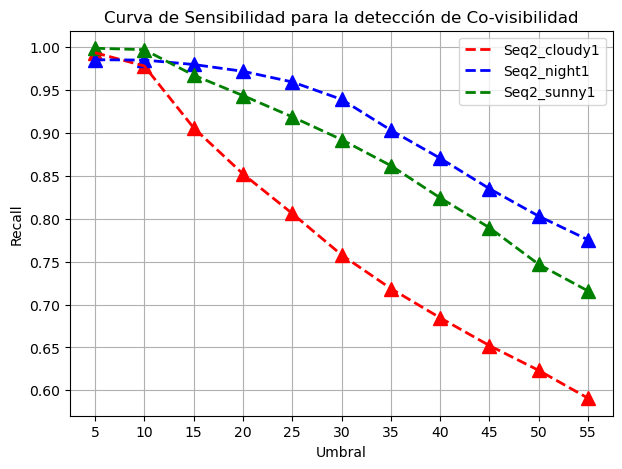

In [26]:
# Create figure
plt.figure(figsize=[7,5])
plt_curve=plt.axes()
 
# Step through the recall lists for each threshold value:
for k in range(len(Trh)):
    # Plot points on recall curve:
    plt_curve.plot(Trh[k],cloudy_R[k],marker='^',markersize=10,color='r') 
    plt_curve.plot(Trh[k],night_R[k],marker='^',markersize=10,color='b') 
    plt_curve.plot(Trh[k],sunny_R[k],marker='^',markersize=10,color='g') 
   
# Plot recall curve
plt_curve.plot(Trh,cloudy_R,color='r',linewidth=2,linestyle='--',label='Seq2_cloudy1')
plt_curve.plot(Trh,night_R,color='b',linewidth=2,linestyle='--',label='Seq2_night1')
plt_curve.plot(Trh,sunny_R,color='g',linewidth=2,linestyle='--',label='Seq2_sunny1')

# Show plot
plt.legend()
plt.title("Curva de Sensibilidad para la detección de Co-visibilidad")
plt.xticks(Trh, Trh)
plt.grid()
plt.xlabel('Umbral')
plt.ylabel('Recall')

Precision-Recall curve

AUC para Seq2_cloudy1:  0.9596975523326542
AUC para Seq2_night1:  0.9836591501628735
AUC para Seq2_sunny1:  0.9877299145450056


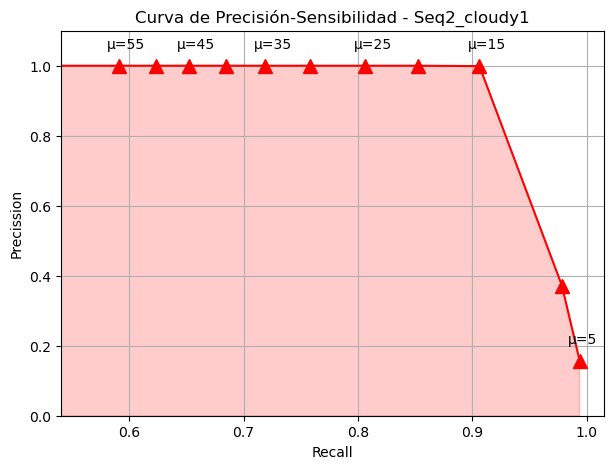

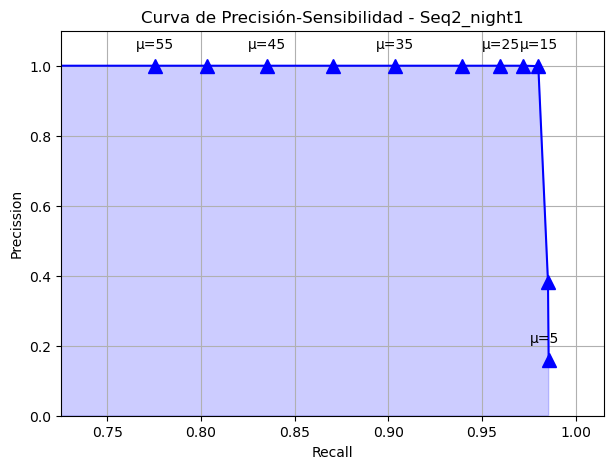

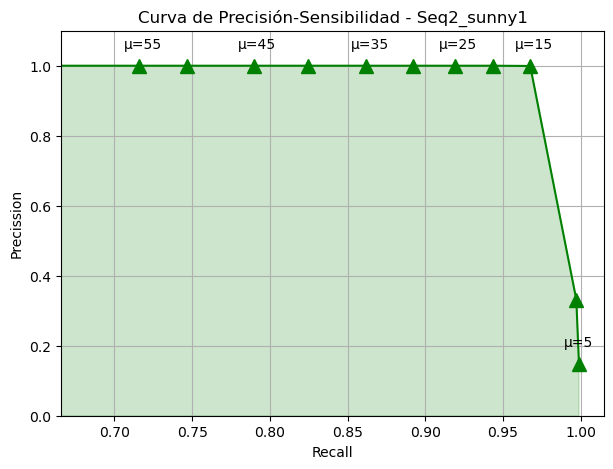

In [31]:
# In this part, the precision-sensitivity curves are plotted for the 3 datasets separately

# Precision and Sensitivity lists for the three datasets
Precision=[cloudy_P,night_P,sunny_P]
Recall=[cloudy_R,night_R,sunny_R]

my_color=['r','b','g']  # Define colors of the plot:
my_label=['Seq2_cloudy1','Seq2_night1','Seq2_sunny1']   # Define labels for the plot

for i in range(3):
    # Create the figure, one for each dataset
    plt.figure(figsize=[7,5])
    plt_curve=plt.axes()

    # Copy Precision and Recall lists
    P=np.copy(Precision[i]).tolist()
    R=np.copy(Recall[i]).tolist()

    # Index the value (P=1, R=0) to correctly calculate the area under the curve
    P.extend([float(1)])
    R.extend([float(0)])

    # Plot points precision and recall
    for k in range(len(Trh)):
        # Plot points
        plt_curve.plot(R[k],P[k],marker='^',markersize=10,color=my_color[i])
        # Plot text with the threshold value at even indices
        if (k%2)== 0: plt_curve.text(R[k]-0.01,P[k]+0.05,"μ="+str(Trh[k]))
  
    # Plot precision-recall curve
    plt_curve.plot(R,P,color=my_color[i],label=my_label[i])    
    plt.fill_between(R,P,color=my_color[i],alpha=0.2)  # Area under the curve shaded

    # Calculate the area under the curve
    auc_score = auc(R, P)
   
    # Show plot:
    plt.grid()
    plt.ylim(0,1.1)
    plt.xlim(R[-2]-0.05,1.015)
    plt.xlabel('Recall')
    plt.ylabel('Precission')
    plt.title("Curva de Precisión-Sensibilidad - "+my_label[i])

    # Print area under the curve:
    print('AUC para '+my_label[i]+': ',auc_score)